# Predicting the directional and future price of bitcoin.

**OVERVIEW**

Predicting the future price for bitcoin.  Firstly, predicting whether the bitcoin price will decline or increase in value, and for what time frames.  And secondly, predicting the actual future price of bitcoin, for a time frame.


### Data Sources
Data sources include free and paid bitcoin historical data.  And may include additional data sets, as required.  

Providing bitcoin historical prices, volume data, technical indicators (RSI), open interest ratios, liquidity levels, the order book, on chain activity, options and their expirations, and market sentiment.  

*Including these data sources:*
- https://github.com/ff137/bitstamp-btcusd-minute-data
- https://finance.yahoo.com
- https://www.bybit.com/future-activity/en/developer
- https://hyblockcapital.com/api-explorer
- https://api.santiment.net


### Data Understanding

Data Consists of Bitmex historical price data in minutes, for Bitcoin.  For **1/1/2012** thru **4/18/2024**.  

*And includes the following columns:*
- timestamp, date and time of the transaction
- open, opening price of bitcoin
- low, low price of bitcoin
- high, high price of bitcoin
- close, close price of bitcoin

Taken from: https://github.com/ff137/bitstamp-btcusd-minute-data

**Additional Data** has been added from: https://finance.yahoo.com

*And includes the following columns:*
- MSTR, Microstrategy Daily Close Price
- ETH-USD, Ethereum Daily Close Price
- ^SPX, Standard and Poor 500 Daily Close Prie




#### Libraries

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error

import numpy as np
from sklearn.model_selection import train_test_split

from pmdarima import auto_arima, ARIMA, model_selection
import yfinance as yf

import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVR
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import warnings

# suppress only the sklearn rename warning
warnings.filterwarnings(
    "ignore",
    message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*",
    category=FutureWarning
)


#### Useful functions for plotting and Data Manipulation

In [229]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Function to plot the future
def plot_future(y, forecast, title):
  # Plot training and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Function to Add the asset's daily closing price as a column to the dataframe
def add_column_with_asset_close(ticker):
    # Account for gap days with the forward fill.  stocks do not trade 24/7, like bitcoin does.
    asset = yf.download(ticker, start="2011-12-30", end="2025-04-18", interval="1d", progress=False, group_by='ticker', auto_adjust=True)  
    asset_close = asset[ticker]['Close'].asfreq('D').ffill()

    column_name = ticker.lower() + ''
    
    asset_close.name = column_name
    df[column_name] = asset_close
    df[column_name] = df[column_name].ffill()    

# Function to add additional bitcoin data, as a column    
def add_column_with_data(data_source_file_name, column_to_import, column_prefix=''):
    df_temp = pd.read_csv(
            f'{DATA_DIR}{data_source_file_name}'
        )

    if "timestamp" in df_temp.columns:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'], unit='ms') # timestamp is in ms
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['openDate'], unit='s') # openDate is in seconds

    # set the datetime timestamp to the index - for date comparison analysis
    df_temp.set_index('timestamp', inplace=True)

    # Resample to daily, account for how these fields should be Aggregated.  open, high, low, close and volume.
    df_temp = df_temp.resample('D').agg({
        column_to_import: 'mean'
    }).round(6)

    # Add new column to existing dataframe
    df[column_prefix + column_to_import] = df_temp[column_to_import]    
  
# Create sequences used by LSTM model
def create_sequences(data, target_index, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_index])  
    return np.array(X), np.array(y)  

def add_column_with_ratio(new_column_name, column_a, column_b):
    # modify - need the ratio
    df[new_column_name] = df[column_a]/df[column_b]

    # drop columns no longer needed
    df.drop([column_a, column_b], axis=1, inplace=True)
    
    
def add_technical_indicator_average_true_range():
    # assume df has columns: 'High', 'Low', 'Close'
    n = 14

    # 1) compute the three components of True Range
    high_low = df['high'] - df['low']
    high_prevclose = (df['high'] - df['close'].shift(1)).abs()
    low_prevclose  = (df['low']  - df['close'].shift(1)).abs()

    # 2) true range is the maximum of those
    df['tr'] = pd.concat([high_low, high_prevclose, low_prevclose], axis=1).max(axis=1)

    # 3a) ATR via simple moving average
    df['atr_sma'] = df['tr'].rolling(window=n).mean()

    # 3b) ATR via Wilder’s smoothing (EMA with alpha=1/n)
    df['atr_wilder'] = df['tr'].ewm(alpha=1/n, adjust=False).mean()


# Inverse scale only 'y' target column
def lstm_inverse_y(preds_scaled, target_index, original_scaler):
    # create zeroed array
    dummy = np.zeros((preds_scaled.shape[0], original_scaler.n_features_in_))
    dummy[:, target_index] = preds_scaled.flatten()
    return original_scaler.inverse_transform(dummy)[:, target_index]

def lstm_predictions(model, X, y, target_index, scaler):
    predictions = model.predict(X)

    predicted_y = lstm_inverse_y(predictions, target_index, scaler)
    actual_y = lstm_inverse_y(y.reshape(-1, 1), target_index, scaler)

    return (predicted_y, actual_y)

def build_lstm_model(hp):
    model = Sequential()
    # Tune number of LSTM units
    model.add(
        LSTM(
            units=hp.Int("units", min_value=32, max_value=64, step=32),
            return_sequences=False,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    # Tune dropout rate
    model.add(
        Dropout(
            rate=hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
        )
    )
    
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
        ),
        loss="mse",
        metrics=["mae"]
    )
    return model

# wrap it for the tuner
def tuner_builder(hp):
    return build_lstm_model(hp)


#### Load the Data

In [230]:
# Load historical and recent data
DATA_DIR = 'data/'
df_hist = pd.read_csv(
    f'{DATA_DIR}btcusd_bitstamp_1min_2012-2025.csv.gz',
    compression='gzip'
)
df_recent = pd.read_csv(
    f'{DATA_DIR}btcusd_bitstamp_1min_latest.csv'
)

# Combine the datasets
df = pd.concat([df_hist, df_recent], ignore_index=True)



### Data Exploration
Bitcoin Pricing Data is in minute data.  Data has been cleaned and validated.  Missing data has been added. 

By using pricing data from https://github.com/ff137/bitstamp-btcusd-minute-data

Duplicates if any will be dropped.  The data will be transformed to daily, rather than minute data.  And correlated assets will be added.


In [231]:
# Information about the df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992075 entries, 0 to 6992074
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 320.1 MB


,timestamp,open,high,low,close,volume
0,1325412060,4.58,4.58,4.58,4.58,0.0
1,1325412120,4.58,4.58,4.58,4.58,0.0
2,1325412180,4.58,4.58,4.58,4.58,0.0
3,1325412240,4.58,4.58,4.58,4.58,0.0
4,1325412300,4.58,4.58,4.58,4.58,0.0


#### Clean and Prepare the Data

In [232]:
#Check for Missing Values
missing_counts = df.isnull().sum().sort_values()
print(missing_counts)

# drop nulls, if any
df = df.dropna()

df.info()

# Remove duplicates, if any.
print("Before removing duplicates:", df.shape)

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992075 entries, 0 to 6992074
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 320.1 MB
Before removing duplicates: (6992075, 6)
After removing duplicates: (6992075, 6)


In [233]:
# convert unix timestamp to datetime timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # timestamp is in seconds

# set the datetime timestamp to the index - for date comparison analysis
df.set_index('timestamp', inplace=True)

# avg, initial values - will be calculated with resample below - increases MAPE to 1.98 from 1.92
#df['avg_open'] = df['open']
#df['avg_high'] = df['high']
#df['avg_low'] = df['low']
#df['avg_close'] = df['close']
#df['high_low'] = df['high'] - df['low']
df['vol_open'] = df['volume']
df['vol_close'] = df['volume']

# keep a copy of the original for lookups
data = df.copy()

df = data.resample('D').agg(
    open = ('open', 'first'),
    vol_open = ('vol_open', 'first'),
    high  = ('high', 'max'),
    vol_high = (
        'high',
        # for each day’s “high” series x, find the timestamp of its max
        # then pull volume from the original data at that timestamp
        lambda x: data.loc[x.idxmax(), 'volume']
    ),
    low = ('low', 'min'),
    vol_low = (
        'low',
        # for each day’s “high” series x, find the timestamp of its max
        # then pull volume from the original data at that timestamp
        lambda x: data.loc[x.idxmax(), 'volume']
    ),
    close =  ('close', 'last'),
    vol_close = ('vol_close', 'last')
    
)



#### Add Additional Bitcoin Data
- Funding Rate
- Long/Short Ratio
- Open Interest
- Taker Buy/Sell Volume


In [234]:
#add_technical_indicator_average_true_range()

# Add Bitcoin Funding Rate - column
add_column_with_data ('funding_rate.csv','funding_rate')



#### Add Correlated Assets 
- Micro Strategy Stock, Daily Closing Prices 
- Ethereum crypto currency, Daily Closing Prices
- S&P500 Index, Daily Closing Prices

In [235]:
#TICKERS = ['MSTR', 'ETH-USD', '^SPX']
#for ticker in TICKERS:
#    add_column_with_asset_close(ticker)

#### Add Economic Indicators
- The Consumer Price Index (CPI, monthly)
- Federal Funds Rate (monthly)
- Chicago Board Options Exchange, Treasury‑yield indices (CBOE, 13 week, 5 year, 10 year, 30 year)
- Univ. of Michigan Consumer Sentiment (monthly)

In [236]:
#INDICATORS = ["^CPI", "^FEDFUNDS", "^IRX", "^FVX", "^TNX", "^UMCSENT"]
#for indicator in INDICATORS:
#    add_column_with_asset_close(indicator)

#### Target 'y' is the next day's closing price, 

In [237]:
df['y'] = df['close'].shift(-1) # target y, we want to predict with historical open, close... tomorrow's 'close'

# drop last row, to avoid 0 value
df = df[:-1] 

df = df.replace([np.inf, -np.inf], 0)

# final data cleanup, not all assets added have data.  For example, ethereum wasn't traded until 2015, and we have bitcoin data since 2012
df = df.fillna(0)

#df.head()
df.tail()

,open,vol_open,high,vol_high,low,vol_low,close,vol_close,funding_rate,y
timestamp,,,,,,,,,,
2025-04-13,85277.0,0.695405,86084.0,16.527331,83031.0,5.680545,83712.0,0.030157,0.000077,84583.0
2025-04-14,83774.0,0.678465,85787.0,2.836901,83680.0,0.851523,84583.0,0.133924,0.000059,83686.0
2025-04-15,84583.0,0.696975,86450.0,11.514443,83612.0,1.498479,83686.0,0.799858,0.000021,84046.0
2025-04-16,83632.0,0.662698,85528.0,2.632607,83102.0,1.334459,84046.0,0.005474,0.000038,84954.0
2025-04-17,84045.0,3.191783,85478.0,1.761941,83751.0,1.155605,84954.0,0.013179,0.000035,84864.0


### Exploratory Data Analysis

#### Explore Correlations

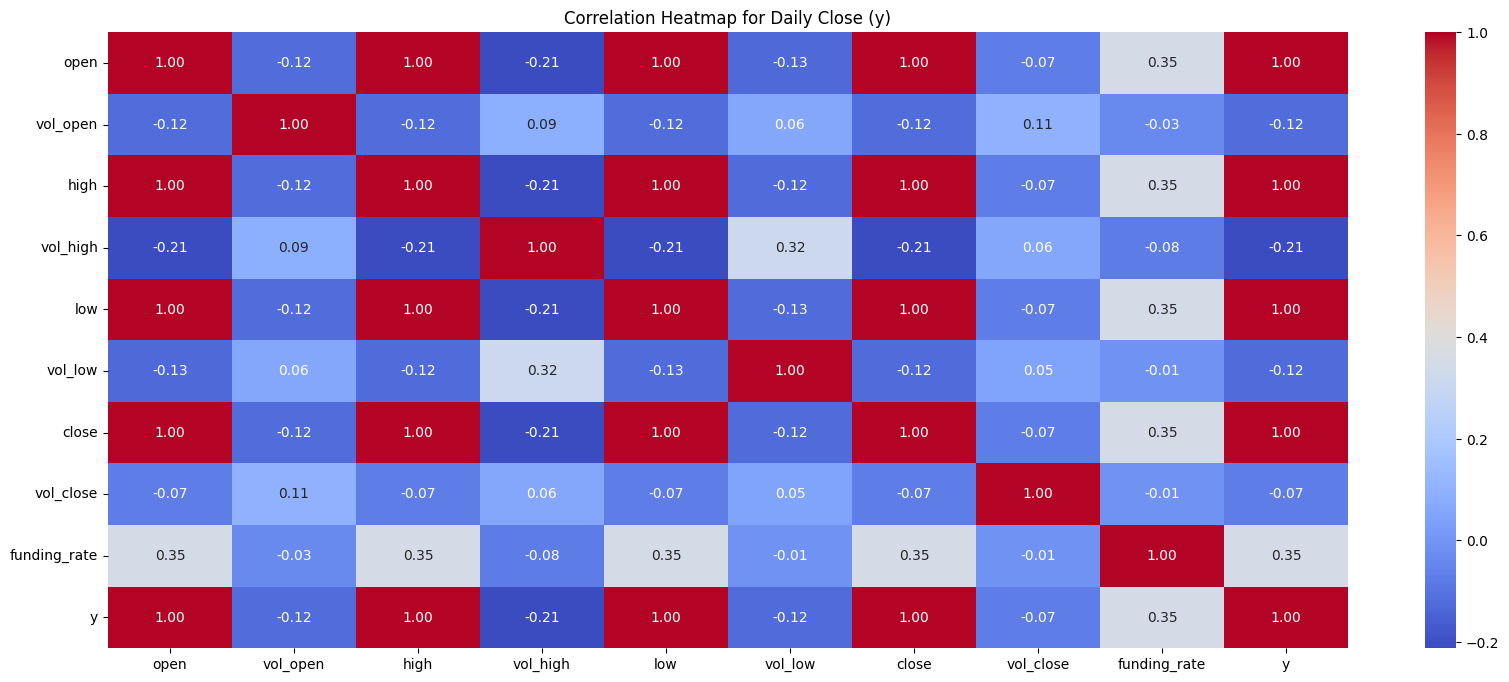

In [238]:
# heatmap of correlation matrix
numerical_subset_df = df.select_dtypes(include=['int64', 'float64'])
corr = numerical_subset_df.corr()

plt.figure(figsize=(20, 8))  # Adjust the size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for Daily Close (y)')
plt.show()

#### Plots of the Closing Price - 'y' target 

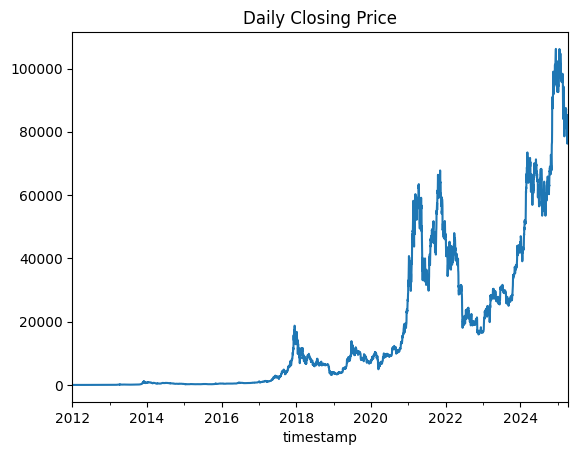

In [239]:
# Daily Closing Price  Plot
df['y'].plot(title = 'Daily Closing Price')
plt.show()

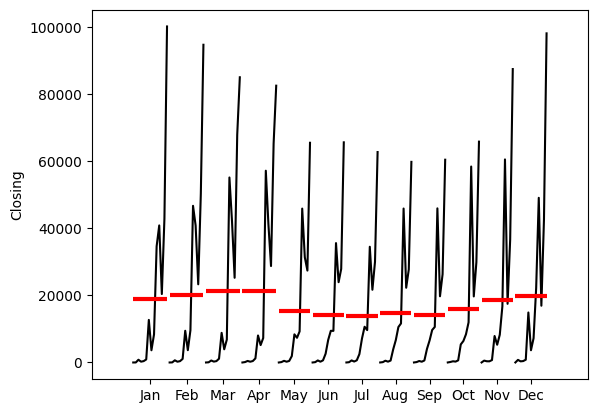

In [240]:
# Plotting the monthly seasonality
month_plot(df['y'].resample('ME').mean(),
           ylabel = 'Closing')
plt.show()

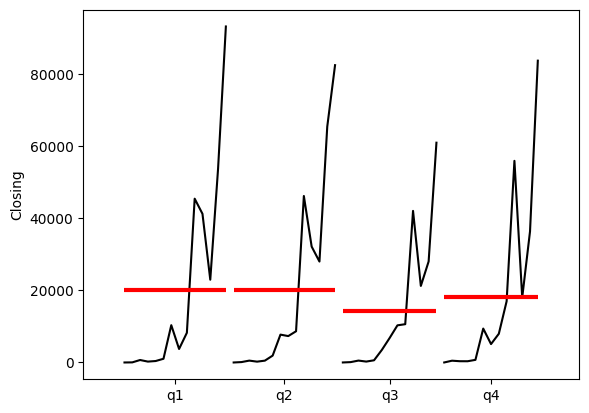

In [241]:
# Plotting the quarterly seasonality
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Closing')
plt.show()

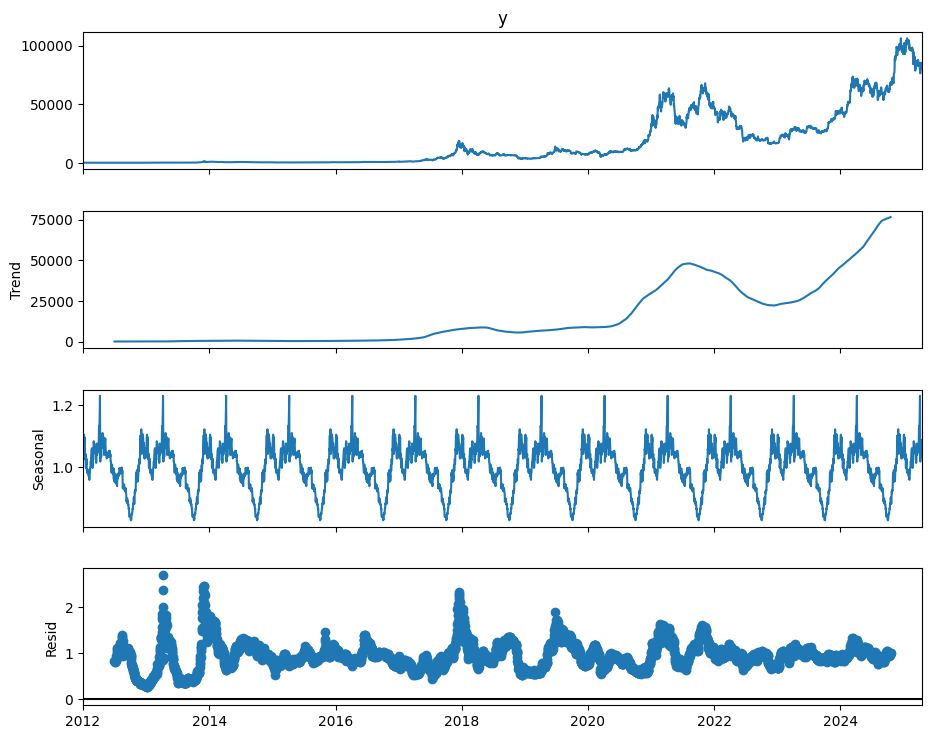

In [242]:
# Seasonal Decomposition Plots for Bitcoin Data
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

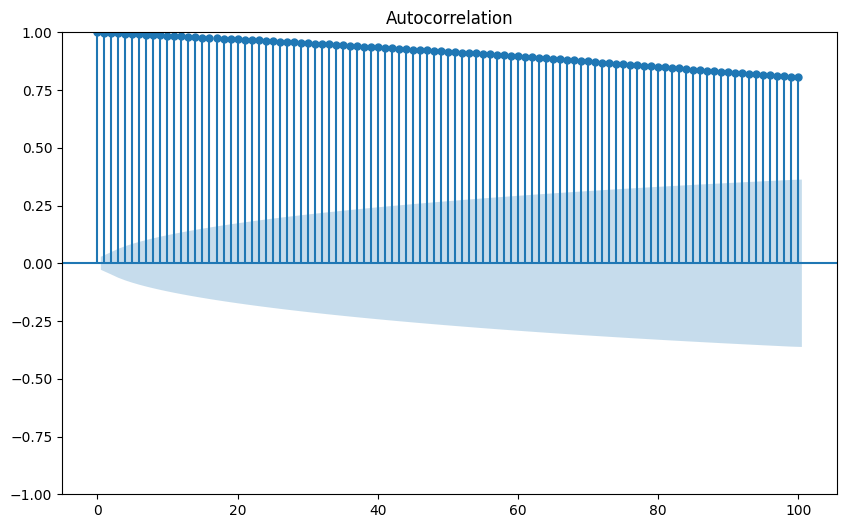

In [243]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

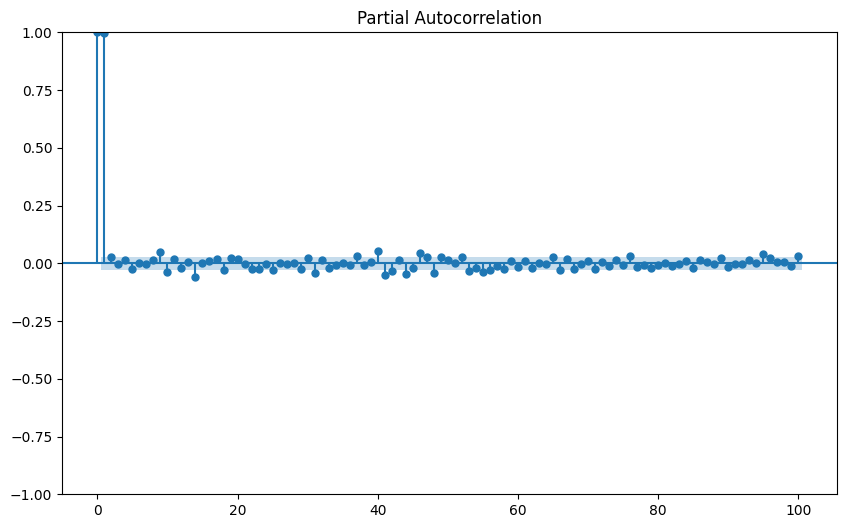

In [244]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

### Feature Engineering

An initial model, for predicting Bitcoin's future price.

In [245]:
X = df.drop(['y'], axis=1)
y = df['y']  # target variable

In [246]:
# Train/Test, 20% for Test.  Split the data - shuffle off - timeseries, in order... a chronological split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [247]:
print(X_train)

                open  vol_open      high   vol_high       low    vol_low  \
timestamp                                                                  
2012-01-01      4.58  0.000000      4.84  10.000000      4.58  10.000000   
2012-01-02      4.84  0.000000      5.00  10.100000      4.84  10.100000   
2012-01-03      5.00  0.000000      5.32   2.419173      5.00   2.419173   
2012-01-04      5.29  0.000000      5.57  43.312196      4.93   0.000000   
2012-01-05      5.57  0.000000      6.46   0.773994      5.57   0.773994   
...              ...       ...       ...        ...       ...        ...   
2022-08-15  24300.00  1.005859  25212.00  10.495257  23900.00  10.495257   
2022-08-16  23997.00  0.033643  24250.00   2.761703  23673.00   0.019900   
2022-08-17  23945.00  0.952784  24448.00  21.492799  23240.00   0.014753   
2022-08-18  23281.00  5.351827  23593.00   0.684498  23176.00   0.609824   
2022-08-19  23351.00  0.038330  23450.00   7.814681  21156.00   0.027590   

           

#### Initial Base Model to Beat, **SARIMAX** on a weekly period

In [248]:
# sarimax, 7 day period
model_sarimax = auto_arima(y_train,
                           m = 7,
                           X = X_train,
                           enforce_invertibility=False, 
                           enforce_stationarity=False)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                 3884
Model:             SARIMAX(2, 0, 0, 7)   Log Likelihood              -30999.789
Date:                 Fri, 16 May 2025   AIC                          62023.578
Time:                         12:30:56   BIC                          62098.754
Sample:                     01-01-2012   HQIC                         62050.266
                          - 08-19-2022                                         
Covariance Type:                   opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
open             0.0002      0.013      0.017      0.987      -0.026       0.026
vol_open         0.1496      1.361      0.110      0.912      -2.518       2.817
high             0.0753      0.017      4.343      0.000       0.041       0.109
vol_high        -0.0274      0.449     -0.061      0.951      -0.908       0.853
low              0.0496      0.011      4.490      0.000       0.028       0.071
vol_low          0.3168      0.709      0.447      0.655      -1.072       1.706
close            0.8735      0.015     57.489      0.000       0.844       0.903
vol_close        0.1084      1.064      0.102      0.919      -1.977       2.193
funding_rate  5.913e+04     24.311   2432.249      0.000    5.91e+04    5.92e+04
ar.S.L7         -0.0295      0.007     -4.068      0.000      -0.044      -0.015
ar.S.L14        -0.0255      0.006     -3.947      0.000      -0.038      -0.013
sigma2        5.031e+05   3550.445    141.702      0.000    4.96e+05     5.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             67004.70
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):            2567.25   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.72e+20. Standard errors may be unstable.
"""

#### Forecast using SARIMAX Model

In [249]:
# Use the fitted Sarimax model to forecast future values.
predictions_arima = model_sarimax.predict(X=X_test, n_periods = len(X_test)) # set the number of periods to forecast to the length of 'test'
predictions_arima

2022-08-20    20981.407782
2022-08-21    21442.352825
2022-08-22    21083.021184
2022-08-23    21471.929083
2022-08-24    21646.953802
                  ...     
2025-04-13    83748.192354
2025-04-14    84516.255093
2025-04-15    83777.282984
2025-04-16    83997.895291
2025-04-17    84819.690092
Freq: D, Length: 972, dtype: float64

#### SARIMAX Model Assessment

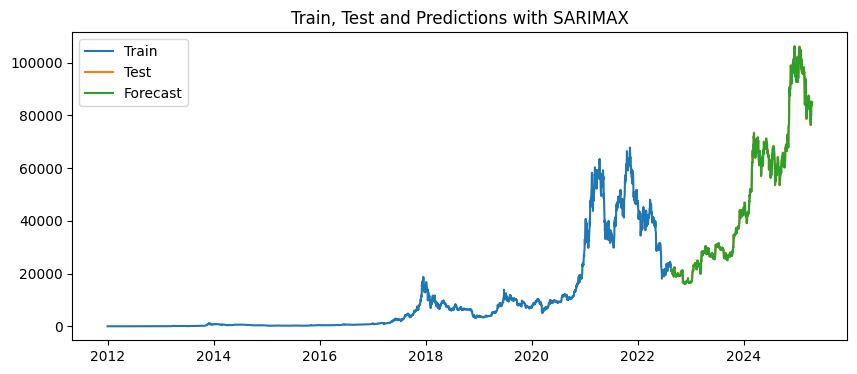

The MAE is 898.27
The RMSE is 1447.08
The MAPE is 1.77 %


In [250]:
# Model assessment
model_assessment(y_train, y_test, predictions_arima, "SARIMAX")

#### Model Exploration

##### Standardize the Data

In [251]:
# Transform the data, standardize
preprocessor = ColumnTransformer(transformers=[('numeric', StandardScaler(), X.columns)])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [252]:
# Define models 
models = {"SVR": SVR(), "Linear Regression": LinearRegression(), "Ridge": Ridge(), "Lasso": Lasso(max_iter=10000), "Random Forest Regressor": RandomForestRegressor(random_state=42), "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42), "XGBoost Regressor": XGBRegressor(random_state=42)}
results = {"Model":[], "Model Predictions":[], "Best Model":[], "Best Parameters":[], "Train Time":[], "Train MAE":[], "Test MAE":[], "Test RMSE":[], "Test MAPE":[]}

In [253]:
# Hyperparameter grids for each model
param_grids = {
    'SVR': {
        'kernel':   ['rbf', 'poly', 'linear', 'sigmoid'],
        'C':        [ 1, 100],   
        'gamma':    [0.001, 0.1, 1]
    },
    'Linear Regression': {
        'fit_intercept': [False, True]
    },
    'Ridge': {
        'alpha': [0.1, 0.001, 1, 10],
        'fit_intercept': [False, True]
    },
    'Lasso': {
        'alpha': [10, 50, 100],
        'tol': [1e-4], #[1e-4, 1e-3, 1e-2],
        'fit_intercept': [True]
    },
    'Random Forest Regressor': {
        'n_estimators': [100, 300, 500],
        'max_depth':    [None, 10, 30],
        'max_features': ['sqrt', 'log2', 0.5, None]
    },
    'Gradient Boosting Regressor': {
        'learning_rate':  [0.01], # 0.05, 0.1, 0.2],
        'n_estimators':   [100, 200, 500],
        'max_depth':      [2],# 3, 5],
        'subsample':      [0.6, 0.8, 1.0]
    },
    'XGBoost Regressor': {
        'n_estimators':      [100, 500],
        'learning_rate':     [0.05, 0.1],
        'max_depth':         [3, 5],
        'subsample':         [0.8, 1.0],
        'colsample_bytree':  [0.8, 1.0],
        'gamma':             [0, 0.1],
        'reg_alpha':         [0, 0.1],
        'reg_lambda':        [1, 1.5]
    }
}


In [254]:
# go thru each model, predict, and score
for model_name, model in models.items():
    train_time_start = time.time()
    
    print(f"Tuning {model_name}...")

    params = param_grids[model_name]
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='neg_mean_absolute_error',
        verbose=1,
        cv=5
    )

    # Fit the grid search
    grid_search.fit(X_train_processed, y_train)
    train_time = time.time() - train_time_start
    
    y_train_predict = grid_search.predict(X_train_processed)
    train_mae = mean_absolute_error(y_train_predict, y_train)

    y_test_predict = grid_search.predict(X_test_processed)
    test_mae = mean_absolute_error(y_test_predict, y_test)
    test_rmse = root_mean_squared_error(y_test_predict, y_test)
    test_mape = round(mean_absolute_percentage_error(y_test_predict, y_test), 2)*100

    results["Model"].append(model_name)
    results["Best Model"].append(grid_search.best_estimator_)
    print(model_name)
    results["Best Parameters"].append(grid_search.best_params_)
    print(grid_search.best_params_)
    results["Model Predictions"].append(y_test_predict)
    results["Train Time"].append(train_time)
    results["Train MAE"].append(train_mae)
    
    results["Test MAE"].append(test_mae)
    results["Test RMSE"].append(test_rmse)
    results["Test MAPE"].append(str(test_mape) + " %")
    

Tuning SVR...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVR
{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
Tuning Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear Regression
{'fit_intercept': True}
Tuning Ridge...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Ridge
{'alpha': 0.001, 'fit_intercept': True}
Tuning Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Lasso
{'alpha': 10, 'fit_intercept': True, 'tol': 0.0001}
Tuning Random Forest Regressor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Regressor
{'max_depth': 10, 'max_features': None, 'n_estimators': 100}
Tuning Gradient Boosting Regressor...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Gradient Boosting Regressor
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.6}
Tuning XGBoost Regressor...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
XGBoost R

In [255]:
# Display the Model Results - dataframe, then print
data_frame_results = pd.DataFrame(results).drop('Model Predictions', axis=1)

print ("Model Results:")
print (data_frame_results)

Model Results:
                         Model  \
0                          SVR   
1            Linear Regression   
2                        Ridge   
3                        Lasso   
4      Random Forest Regressor   
5  Gradient Boosting Regressor   
6            XGBoost Regressor   

                                          Best Model  \
0           SVR(C=100, gamma=0.001, kernel='linear')   
1                                 LinearRegression()   
2                                 Ridge(alpha=0.001)   
3                    Lasso(alpha=10, max_iter=10000)   
4  (DecisionTreeRegressor(max_depth=10, random_st...   
5  ([DecisionTreeRegressor(criterion='friedman_ms...   
6  XGBRegressor(base_score=None, booster=None, ca...   

                                     Best Parameters  Train Time   Train MAE  \
0     {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}  375.155193  296.880796   
1                            {'fit_intercept': True}    0.011183  281.598381   
2            {'alpha': 

In [256]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df)

# Create Sequences for all data
SEQUENCE_LENGTH = 60
target_index = df.columns.get_loc('y')
X, y = create_sequences(scaled_data, target_index, seq_len=SEQUENCE_LENGTH)

# Train/Test, 20% for Test.  Split the data - shuffle off - timeseries, in order... a chronological split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [259]:
results = []

# set up Hyperband tuner
tuner = kt.Hyperband(
    tuner_builder,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='kt_dir',
    project_name='lstm_tuning'
)

# early stopping so we don't waste epochs
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# launch search
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[stop_early]
)

# inspect top trials
tuner.results_summary()

best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
val_loss = tuner.oracle.get_best_trials(1)[0].score

y_pred, y_actual = lstm_predictions(best_model, X_test, y_test, target_index, scaler)

mae = mean_absolute_error(y_actual, y_pred)
rmse = root_mean_squared_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)
print(mape)

results.append({
    'batch_size': 32,
    'val_loss': val_loss,
    'hyperparams': best_hp.values,
    'model': best_model,
    'mae': mae,
    'rmse': rmse,
    'mape': mape
})


best_result = min(results, key=lambda x: x['val_loss'])

print("\n✅ Best Result:")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Validation Loss: {best_result['val_loss']:.4f}")
print(f"Hyperparameters: {best_result['hyperparams']}")
print(f"MAE: {best_result['mae']:.2f}, RMSE: {best_result['rmse']:.2f}, MAPE: {best_result['mape']*100:.2f}%")


# original 14.11%

# 2.63% if no other columns, 64 units, 32 batch size, sequence 60
# MAPE: 10.73% with everything.  hyblock and additional columns.
# MAPE: 34% with everything.
# MAPE: 28.01% with everything.

Reloading Tuner from kt_dir/lstm_tuning/tuner0.json
Results summary
Results in kt_dir/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
units: 32
dropout: 0.1
lr: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.0018254263559356332

Trial 0003 summary
Hyperparameters:
units: 64
dropout: 0.4
lr: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.0020851686131209135

Trial 0022 summary
Hyperparameters:
units: 32
dropout: 0.4
lr: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.002094689290970564

Trial 0021 summary
Hyperparameters:
units: 64
dropout: 0.30000000000000004
lr: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.0021226524841040373

Trial 0020 summary
Hyperparameters:
units: 32
dropout: 0.30000000000000004
lr: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tun

/Users/shawnarney/miniforge3/envs/keras2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/shawnarney/miniforge3/envs/keras2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
0.03827556240434506

✅ Best Result:
Batch Size: 32
Validation Loss: 0.0018
Hyperparameters: {'units': 32, 'dropout': 0.1, 'lr': 0.01, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}
MAE: 2172.39, RMSE: 3326.28, MAPE: 3.83%
